In [ ]:
import numpy as np
from PIL import Image

import os
import numpy as np
from random import shuffle
import json
import random

from scipy.ndimage import gaussian_filter, maximum_filter
import copy

import tensorflow as tf
import datetime
from time import time

from scipy.io import loadmat
from numpy import transpose
import skimage.io as sio

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def get_transform(center, scale, res, rot=0):
    """
    General image processing functions
    """
    # Generate transformation matrix
    h = 200 * scale
    t = np.zeros((3, 3))
    t[0, 0] = float(res[1]) / h
    t[1, 1] = float(res[0]) / h
    t[0, 2] = res[1] * (-float(center[0]) / h + 0.5)
    t[1, 2] = res[0] * (-float(center[1]) / h + 0.5)
    t[2, 2] = 1
    if not rot == 0:
        rot = -rot  # To match direction of rotation from cropping
        rot_mat = np.zeros((3, 3))
        rot_rad = rot * np.pi / 180
        sn, cs = np.sin(rot_rad), np.cos(rot_rad)
        rot_mat[0, :2] = [cs, -sn]
        rot_mat[1, :2] = [sn, cs]
        rot_mat[2, 2] = 1
        # Need to rotate around center
        t_mat = np.eye(3)
        t_mat[0, 2] = -res[1] / 2
        t_mat[1, 2] = -res[0] / 2
        t_inv = t_mat.copy()
        t_inv[:2, 2] *= -1
        t = np.dot(t_inv, np.dot(rot_mat, np.dot(t_mat, t)))
    return t


def transform(pt, center, scale, res, invert=0, rot=0):
    # Transform pixel location to different reference
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        t = np.linalg.inv(t)
    new_pt = np.array([pt[0] - 1, pt[1] - 1, 1.0]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int) + 1


def crop(img, center, scale, res, rot=0):
    # Preprocessing for efficient cropping
    ht, wd = img.shape[0], img.shape[1]
    sf = scale * 200.0 / res[0]
    if sf < 2:
        sf = 1
    else:
        new_size = int(np.math.floor(max(ht, wd) / sf))
        new_ht = int(np.math.floor(ht / sf))
        new_wd = int(np.math.floor(wd / sf))
        img = np.array(Image.fromarray(img).resize((new_wd, new_ht)))
        center = center * 1.0 / sf
        scale = scale / sf

    # Upper left point
    ul = np.array(transform([0, 0], center, scale, res, invert=1))
    # Bottom right point
    br = np.array(transform(res, center, scale, res, invert=1))

    # Padding so that when rotated proper amount of context is included
    pad = int(np.linalg.norm(br - ul) / 2 - float(br[1] - ul[1]) / 2)
    if not rot == 0:
        ul -= pad
        br += pad

    new_shape = [br[1] - ul[1], br[0] - ul[0]]
    if len(img.shape) > 2:
        new_shape += [img.shape[2]]
    new_img = np.zeros(new_shape)

    # Range to fill new array
    new_x = max(0, -ul[0]), min(br[0], len(img[0])) - ul[0]
    new_y = max(0, -ul[1]), min(br[1], len(img)) - ul[1]
    # Range to sample from original image
    old_x = max(0, ul[0]), min(len(img[0]), br[0])
    old_y = max(0, ul[1]), min(len(img), br[1])
    new_img[new_y[0] : new_y[1], new_x[0] : new_x[1]] = img[
        old_y[0] : old_y[1], old_x[0] : old_x[1]
    ]

    if not rot == 0:
        # Remove padding
        new_img = np.array(Image.fromarray(new_img.astype(np.uint8)).rotate(rot))
        new_img = new_img[pad:-pad, pad:-pad]

    new_img = Image.fromarray(new_img.astype(np.uint8))
    new_img = np.array(new_img.resize(res))  # scipy.misc.imresize(new_img, res)
    return new_img


def normalize(imgdata, color_mean):
    """
    :param imgdata: image in 0 ~ 255
    :return:  image from 0.0 to 1.0
    """
    imgdata = imgdata / 255.0

    for i in range(imgdata.shape[-1]):
        imgdata[:, :, i] -= color_mean[i]

    return imgdata


def draw_labelmap(img, pt, sigma, type="Gaussian"):
    # Draw a 2D gaussian
    # Adopted from https://github.com/anewell/pose-hg-train/blob/master/src/pypose/draw.py

    # Check that any part of the gaussian is in-bounds
    ul = [int(pt[0] - 3 * sigma), int(pt[1] - 3 * sigma)]
    br = [int(pt[0] + 3 * sigma + 1), int(pt[1] + 3 * sigma + 1)]
    if ul[0] >= img.shape[1] or ul[1] >= img.shape[0] or br[0] < 0 or br[1] < 0:
        # If not, just return the image as is
        return img

    # Generate gaussian
    size = 6 * sigma + 1
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    # The gaussian is not normalized, we want the center value to equal 1
    if type == "Gaussian":
        g = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma**2))
    elif type == "Cauchy":
        g = sigma / (((x - x0) ** 2 + (y - y0) ** 2 + sigma**2) ** 1.5)

    # Usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]
    # Image range
    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])

    img[img_y[0] : img_y[1], img_x[0] : img_x[1]] = g[g_y[0] : g_y[1], g_x[0] : g_x[1]]
    return img


def transform_kp(joints, center, scale, res, rot):
    newjoints = np.copy(joints)
    for i in range(joints.shape[0]):
        if joints[i, 0] > 0 and joints[i, 1] > 0:
            _x = transform(
                newjoints[i, 0:2] + 1,
                center=center,
                scale=scale,
                res=res,
                invert=0,
                rot=rot,
            )
            newjoints[i, 0:2] = _x
    return newjoints


def generate_gtmap(joints, sigma, outres):
    npart = joints.shape[0]
    gtmap = np.zeros(shape=(outres[0], outres[1], npart), dtype=float)
    for i in range(npart):
        visibility = joints[i, 2]
        if visibility > 0:
            gtmap[:, :, i] = draw_labelmap(gtmap[:, :, i], joints[i, :], sigma)
    return gtmap

In [ ]:
class MPIIDataGen(object):
    def __init__(self, jsonfile, imgpath, inres, outres, is_train):
        self.jsonfile = jsonfile
        self.imgpath = imgpath
        self.inres = inres
        self.outres = outres
        self.is_train = is_train
        self.nparts = 16
        self.anno = self._load_image_annotation()

    def _load_image_annotation(self):
        # load train or val annotation
        with open(self.jsonfile) as anno_file:
            anno = json.load(anno_file)

        val_anno, train_anno = [], []
        for idx, val in enumerate(anno):
            if val["isValidation"] == True:
                val_anno.append(anno[idx])
            else:
                train_anno.append(anno[idx])

        if self.is_train:
            return train_anno
        else:
            return val_anno

    def get_dataset_size(self):
        return len(self.anno)

    def get_color_mean(self):
        mean = np.array([0.4404, 0.4440, 0.4327], dtype=np.float64)
        return mean

    def get_annotations(self):
        return self.anno

    def generator(
        self,
        batch_size,
        num_hgstack,
        sigma=1,
        with_meta=False,
        is_shuffle=False,
        rot_flag=False,
        scale_flag=False,
        flip_flag=False,
    ):
        """
        Input:  batch_size * inres  * Channel (3)
        Output: batch_size * oures  * nparts
        """
        train_input = np.zeros(
            shape=(batch_size, self.inres[0], self.inres[1], 3), dtype=np.float64
        )
        gt_heatmap = np.zeros(
            shape=(batch_size, self.outres[0], self.outres[1], self.nparts),
            dtype=np.float64,
        )
        meta_info = list()

        if not self.is_train:
            assert is_shuffle == False, "shuffle must be off in val model"
            assert rot_flag == False, "rot_flag must be off in val model"

        while True:
            if is_shuffle:
                shuffle(self.anno)

            for i, kpanno in enumerate(self.anno):
                _imageaug, _gthtmap, _meta = self.process_image(
                    i, kpanno, sigma, rot_flag, scale_flag, flip_flag
                )
                _index = i % batch_size

                train_input[_index, :, :, :] = _imageaug
                gt_heatmap[_index, :, :, :] = _gthtmap
                meta_info.append(_meta)

                if i % batch_size == (batch_size - 1):
                    out_hmaps = []
                    for m in range(num_hgstack):
                        out_hmaps.append(gt_heatmap)

                    if with_meta:
                        yield [
                            train_input,
                            train_input,
                            train_input,
                        ], gt_heatmap, meta_info  # train_input, out_hmaps, meta_info
                        meta_info = []
                    else:
                        yield [
                            train_input,
                            train_input,
                            train_input,
                        ], gt_heatmap  # train_input, out_hmaps

    def process_image(
        self, sample_index, kpanno, sigma, rot_flag, scale_flag, flip_flag
    ):
        imagefile = kpanno["img_paths"]
        image = Image.open(
            os.path.join(self.imgpath, imagefile)
        )  # scipy.misc.imread(os.path.join(self.imgpath, imagefile))
        image = np.array(image)
        # get center
        center = np.array(kpanno["objpos"])
        joints = np.array(kpanno["joint_self"])
        scale = kpanno["scale_provided"]

        # Adjust center/scale slightly to avoid cropping limbs
        if center[0] != -1:
            center[1] = center[1] + 15 * scale
            scale = scale * 1.25

        # filp
        if flip_flag and random.choice([0, 1]):
            image, joints, center = self.flip(image, joints, center)

        # scale
        if scale_flag:
            scale = scale * np.random.uniform(0.8, 1.2)

        # rotate image
        if rot_flag and random.choice([0, 1]):
            rot = np.random.randint(-1 * 30, 30)
        else:
            rot = 0

        cropimg = crop(image, center, scale, self.inres, rot)
        cropimg = normalize(cropimg, self.get_color_mean())

        # transform keypoints
        transformedKps = transform_kp(joints, center, scale, self.outres, rot)
        gtmap = generate_gtmap(transformedKps, sigma, self.outres)

        # meta info
        metainfo = {
            "sample_index": sample_index,
            "center": center,
            "scale": scale,
            "pts": joints,
            "tpts": transformedKps,
            "name": imagefile,
        }

        return cropimg, gtmap, metainfo

    @classmethod
    def get_kp_keys(cls):
        keys = [
            "r_ankle",
            "r_knee",
            "r_hip",
            "l_hip",
            "l_knee",
            "l_ankle",
            "plevis",
            "thorax",
            "upper_neck",
            "head_top",
            "r_wrist",
            "r_elbow",
            "r_shoulder",
            "l_shoulder",
            "l_elbow",
            "l_wrist",
        ]
        return keys

    def flip(self, image, joints, center):
        import cv2

        joints = np.copy(joints)

        matchedParts = (
            [0, 5],  # ankle
            [1, 4],  # knee
            [2, 3],  # hip
            [10, 15],  # wrist
            [11, 14],  # elbow
            [12, 13],  # shoulder
        )

        org_height, org_width, channels = image.shape

        # flip image
        flipimage = cv2.flip(image, flipCode=1)

        # flip each joints
        joints[:, 0] = org_width - joints[:, 0]

        for i, j in matchedParts:
            temp = np.copy(joints[i, :])
            joints[i, :] = joints[j, :]
            joints[j, :] = temp

        # center
        flip_center = center
        flip_center[0] = org_width - center[0]

        return flipimage, joints, flip_center

In [ ]:
def post_process_heatmap(heatMap, kpConfidenceTh=0.2):
    kplst = list()
    for i in range(heatMap.shape[-1]):
        # ignore last channel, background channel
        _map = heatMap[:, :, i]
        _map = gaussian_filter(_map, sigma=0.5)
        _nmsPeaks = non_max_supression(_map, windowSize=3, threshold=1e-6)

        y, x = np.where(_nmsPeaks == _nmsPeaks.max())
        if len(x) > 0 and len(y) > 0:
            kplst.append((int(x[0]), int(y[0]), _nmsPeaks[y[0], x[0]]))
        else:
            kplst.append((0, 0, 0))
    return kplst


def non_max_supression(plain, windowSize=3, threshold=1e-6):
    # clear value less than threshold
    under_th_indices = plain < threshold
    plain[under_th_indices] = 0
    return plain * (
        plain == maximum_filter(plain, footprint=np.ones((windowSize, windowSize)))
    )

In [ ]:
def get_predicted_kp_from_htmap(heatmap, meta, outres):
    # nms to get location
    kplst = post_process_heatmap(heatmap)
    kps = np.array(kplst)

    # use meta information to transform back to original image
    mkps = copy.copy(kps)
    for i in range(kps.shape[0]):
        mkps[i, 0:2] = transform(
            kps[i], meta["center"], meta["scale"], res=outres, invert=1, rot=0
        )

    return mkps


def cal_kp_distance(pre_kp, gt_kp, norm, threshold):
    if gt_kp[0] > 1 and gt_kp[1] > 1:
        dif = np.linalg.norm(gt_kp[0:2] - pre_kp[0:2]) / norm
        if dif < threshold:
            # good prediction
            return 1
        else:  # failed
            return 0
    else:
        return -1


def heatmap_accuracy(predhmap, meta, norm, threshold):
    pred_kps = post_process_heatmap(predhmap)
    pred_kps = np.array(pred_kps)

    gt_kps = meta["tpts"]

    good_pred_count = 0
    failed_pred_count = 0
    for i in range(gt_kps.shape[0]):
        dis = cal_kp_distance(pred_kps[i, :], gt_kps[i, :], norm, threshold)
        if dis == 0:
            failed_pred_count += 1
        elif dis == 1:
            good_pred_count += 1

    return good_pred_count, failed_pred_count


def cal_heatmap_acc(prehmap, metainfo, threshold):
    sum_good, sum_fail = 0, 0
    for i in range(prehmap.shape[0]):
        _prehmap = prehmap[i, :, :, :]
        good, bad = heatmap_accuracy(
            _prehmap, metainfo[i], norm=6.4, threshold=threshold
        )

        sum_good += good
        sum_fail += bad

    return sum_good, sum_fail

In [ ]:
class EvalCallBack(tf.keras.callbacks.Callback):
    def __init__(self, foldpath, inres, outres):
        self.foldpath = foldpath
        self.inres = inres
        self.outres = outres

    def get_folder_path(self):
        return self.foldpath

    def run_eval(self, epoch):
        valdata = MPIIDataGen(
            "../input/staked-hourglass-networks/mpii_annotations.json",
            "../input/mpii-dataset-for-python/dataset/images",
            inres=self.inres,
            outres=self.outres,
            is_train=False,
        )

        total_suc, total_fail = 0, 0
        threshold = 0.5

        count = 0
        batch_size = 8
        for _img, _gthmap, _meta in valdata.generator(
            batch_size, 8, sigma=2, is_shuffle=False, with_meta=True
        ):
            count += batch_size
            if count > valdata.get_dataset_size():
                break

            out = self.model.predict(_img)

            suc, bad = cal_heatmap_acc(out, _meta, threshold)

            total_suc += suc
            total_fail += bad

        acc = total_suc * 1.0 / (total_fail + total_suc)

        print("Eval Accuray ", acc, "@ Epoch ", epoch)

        with open(os.path.join(self.get_folder_path(), "val.txt"), "a+") as xfile:
            xfile.write("Epoch " + str(epoch) + ":" + str(acc) + "\n")

    def on_epoch_end(self, epoch, logs=None):
        # This is a walkaround to sovle model.save() issue
        # in which large network can't be saved due to size.

        # save model to json
        if epoch == 0:
            jsonfile = os.path.join(self.foldpath, "net_arch.json")
            with open(jsonfile, "w") as f:
                f.write(self.model.to_json())

        # save weights
        modelName = os.path.join(self.foldpath, "weights_epoch" + str(epoch) + ".h5")
        self.model.save_weights(modelName)

        print("Saving model to ", modelName)

        self.run_eval(epoch)

In [ ]:
def run_pckh(model_name, predfile):
    detection = loadmat(
        "../input/staked-hourglass-networks/pytorch-pose-master/pytorch-pose-master/evaluation/data/detections.mat"
    )
    det_idxs = detection["RELEASE_img_index"]
    debug = 0
    threshold = 0.5
    SC_BIAS = 0.6

    pa = [2, 3, 7, 7, 4, 5, 8, 9, 10, 0, 12, 13, 8, 8, 14, 15]

    dict = loadmat(
        "../input/staked-hourglass-networks/pytorch-pose-master/pytorch-pose-master/evaluation/data/detections_our_format.mat"
    )
    print(dict.keys())
    dataset_joints = dict["dataset_joints"]
    jnt_missing = dict["jnt_missing"]
    pos_pred_src = dict["pos_pred_src"]
    pos_gt_src = dict["pos_gt_src"]
    headboxes_src = dict["headboxes_src"]

    # predictions
    preds = loadmat(predfile)["preds"]
    pos_pred_src = transpose(preds, [1, 2, 0])

    if debug:
        for i in range(len(det_idxs[0])):
            anno = mat["RELEASE"]["annolist"][0, 0][0][det_idxs[0][i] - 1]
            fn = anno["image"]["name"][0, 0][0]
            imagePath = "../input/mpii-dataset-for-python/dataset/images" + fn
            oriImg = np.array(Image.open(imagePath))  # sio.imread(imagePath)
            pred = pos_pred_src[:, :, i]
            visualize(oriImg, pred, pa)

    head = np.where(dataset_joints == "head")[1][0]
    lsho = np.where(dataset_joints == "lsho")[1][0]
    lelb = np.where(dataset_joints == "lelb")[1][0]
    lwri = np.where(dataset_joints == "lwri")[1][0]
    lhip = np.where(dataset_joints == "lhip")[1][0]
    lkne = np.where(dataset_joints == "lkne")[1][0]
    lank = np.where(dataset_joints == "lank")[1][0]

    rsho = np.where(dataset_joints == "rsho")[1][0]
    relb = np.where(dataset_joints == "relb")[1][0]
    rwri = np.where(dataset_joints == "rwri")[1][0]
    rkne = np.where(dataset_joints == "rkne")[1][0]
    rank = np.where(dataset_joints == "rank")[1][0]
    rhip = np.where(dataset_joints == "rhip")[1][0]

    jnt_visible = 1 - jnt_missing
    uv_error = pos_pred_src - pos_gt_src
    uv_err = np.linalg.norm(uv_error, axis=1)
    headsizes = headboxes_src[1, :, :] - headboxes_src[0, :, :]
    headsizes = np.linalg.norm(headsizes, axis=0)
    headsizes *= SC_BIAS
    scale = np.multiply(headsizes, np.ones((len(uv_err), 1)))
    scaled_uv_err = np.divide(uv_err, scale)
    scaled_uv_err = np.multiply(scaled_uv_err, jnt_visible)
    jnt_count = np.sum(jnt_visible, axis=1)
    less_than_threshold = np.multiply((scaled_uv_err < threshold), jnt_visible)
    PCKh = np.divide(100.0 * np.sum(less_than_threshold, axis=1), jnt_count)

    # save
    rng = np.arange(0, 0.5, 0.01)
    pckAll = np.zeros((len(rng), 16))

    for r in range(len(rng)):
        threshold = rng[r]
        less_than_threshold = np.multiply(scaled_uv_err < threshold, jnt_visible)
        pckAll[r, :] = np.divide(100.0 * np.sum(less_than_threshold, axis=1), jnt_count)

    name = predfile.split(os.sep)[-1]
    PCKh = np.ma.array(PCKh, mask=False)
    PCKh.mask[6:8] = True
    print("Model,  Head,   Shoulder, Elbow,  Wrist,   Hip ,     Knee  , Ankle ,  Mean")
    print(
        "{:s}   {:.2f}  {:.2f}     {:.2f}  {:.2f}   {:.2f}   {:.2f}   {:.2f}   {:.2f}".format(
            model_name,
            PCKh[head],
            0.5 * (PCKh[lsho] + PCKh[rsho]),
            0.5 * (PCKh[lelb] + PCKh[relb]),
            0.5 * (PCKh[lwri] + PCKh[rwri]),
            0.5 * (PCKh[lhip] + PCKh[rhip]),
            0.5 * (PCKh[lkne] + PCKh[rkne]),
            0.5 * (PCKh[lank] + PCKh[rank]),
            np.mean(PCKh),
        )
    )

In [ ]:
def get_number(valfile):
    with open(valfile) as xfile:
        lines = xfile.readlines()

    scores = []
    for _line in lines:
        _line = _line.strip()
        val_score = float(_line.split(":")[-1])
        scores.append(val_score)

    return scores


def main_plot(vallst):
    for valfile in vallst:
        valname = os.path.basename(os.path.dirname(valfile))
        score = get_number(valfile)
        plt.plot(score, label=valname)

    plt.title("MPII val score")
    plt.legend()
    plt.show()

In [ ]:
os.mkdir("Ensemble")
model_path = "./Ensemble"

In [ ]:
model = tf.keras.applications.DenseNet121(
    include_top=False, weights=None, input_shape=(256, 256, 3)
)
layer64a = model.get_layer("conv2_block3_2_conv")  # 32
layer64c = model.get_layer("conv2_block6_concat")  # 256

layer32a = model.get_layer("conv3_block5_1_relu")  # 128
layer32c = model.get_layer("conv3_block8_concat")  # 384

layer16a = model.get_layer("conv4_block5_1_relu")  # 128
layer16c = model.get_layer("conv4_block10_concat")  # 576

last_layer = model.get_layer("conv4_block17_1_relu")
mod = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    last_layer.output
)  # 16x16
mod = tf.keras.layers.concatenate([mod, layer16c.output])
mod = tf.keras.layers.BatchNormalization()(mod)
mod = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.concatenate([mod, layer16a.output])
mod = tf.keras.layers.BatchNormalization()(mod)

mod = tf.keras.layers.UpSampling2D((2, 2))(mod)  # 32x32
mod = tf.keras.layers.concatenate([mod, layer32c.output])
mod = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.concatenate([mod, layer32a.output])
mod = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.BatchNormalization()(mod)

mod = tf.keras.layers.UpSampling2D((2, 2))(mod)  # 64x64
mod = tf.keras.layers.concatenate([mod, layer64c.output])
mod = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.concatenate([mod, layer64a.output])
mod = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.BatchNormalization()(mod)

Output = tf.keras.layers.Conv2D(16, (1, 1), activation=tf.nn.sigmoid, padding="same")(
    mod
)
Model_D = tf.keras.Model(model.input, Output)
###############################################################
model = tf.keras.applications.Xception(
    include_top=False, weights="imagenet", input_shape=(256, 256, 3)
)


layer63_1 = model.get_layer("block3_sepconv1_act")  # 128
layer63_2 = model.get_layer("block3_sepconv2")  # 256

layer32_1 = model.get_layer("block4_sepconv1_act")  # 128
layer32_2 = model.get_layer("block4_sepconv2_act")  # 728

layer16_1 = model.get_layer("block5_sepconv1")  # 728
layer16_2 = model.get_layer("block5_sepconv3")  # 728

last_layer = model.get_layer("block6_sepconv1")  # 728

mod = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    last_layer.output
)  # 16x16
mod = tf.keras.layers.concatenate([mod, layer16_2.output])
mod = tf.keras.layers.BatchNormalization()(mod)
mod = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.concatenate([mod, layer16_1.output])
mod = tf.keras.layers.BatchNormalization()(mod)

mod = tf.keras.layers.UpSampling2D((2, 2))(mod)  # 32x32
mod = tf.keras.layers.concatenate([mod, layer32_2.output])
mod = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.concatenate([mod, layer32_1.output])
mod = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.BatchNormalization()(mod)

mod = tf.keras.layers.UpSampling2D((2, 2))(mod)  # 64x64
mod = tf.keras.layers.Conv2D(32, (2, 2), activation=tf.nn.leaky_relu, padding="valid")(
    mod
)
mod = tf.keras.layers.concatenate([mod, layer63_2.output])
mod = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.concatenate([mod, layer63_1.output])
mod = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu, padding="same")(
    mod
)
mod = tf.keras.layers.BatchNormalization()(mod)
mod = tf.keras.layers.ZeroPadding2D(1)(mod)
mod = tf.keras.layers.Conv2D(16, (2, 2), activation=tf.nn.leaky_relu, padding="valid")(
    mod
)
mod = tf.keras.layers.BatchNormalization()(mod)

Output = tf.keras.layers.Conv2D(16, (1, 1), activation=tf.nn.sigmoid, padding="same")(
    mod
)
Model_X = tf.keras.Model(model.input, Output)


###########################################
model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(256, 256, 3)
)
c4_f = model.get_layer("conv4_block2_2_relu")

c3_f = model.get_layer("conv3_block2_2_relu")
c3_l = model.get_layer("conv3_block4_2_relu")

c2_f = model.get_layer("conv2_block1_out")

last = model.get_layer("conv4_block6_2_relu")

c1 = tf.keras.layers.Conv2D(
    256, (3, 3), padding="same", activation=tf.nn.leaky_relu, name="first"
)(last.output)
c1 = tf.keras.layers.concatenate([c1, c4_f.output])
c1 = tf.keras.layers.Conv2D(
    256, (3, 3), activation=tf.nn.leaky_relu, padding="same", name="second"
)(c1)
c1 = tf.keras.layers.BatchNormalization()(c1)

d1 = tf.keras.layers.Conv2DTranspose(
    128, kernel_size=(4, 4), strides=2, padding="same", activation=tf.nn.leaky_relu
)(c1)
d1 = tf.keras.layers.concatenate([d1, c3_l.output])
d1 = tf.keras.layers.Conv2D(
    128, (3, 3), padding="same", activation=tf.nn.leaky_relu, name="three"
)(d1)
d1 = tf.keras.layers.concatenate([d1, c3_f.output])
d1 = tf.keras.layers.Conv2D(
    128, (3, 3), padding="same", activation=tf.nn.leaky_relu, name="four"
)(d1)
d1 = tf.keras.layers.BatchNormalization()(d1)

d2 = tf.keras.layers.Conv2DTranspose(
    64, kernel_size=(4, 4), strides=2, padding="same", activation=tf.nn.leaky_relu
)(d1)
d2 = tf.keras.layers.concatenate([d2, c2_f.output])
d2 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation=tf.nn.leaky_relu)(d2)
d2 = tf.keras.layers.BatchNormalization()(d2)

d2 = tf.keras.layers.Conv2D(16, (1, 1), padding="same", activation="sigmoid")(d2)

Model_R = tf.keras.Model(model.input, d2)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(Model_1, to_file='model_ensemble.png', show_shapes=True, show_layer_names=True)

In [ ]:
Model_R.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
Model_X.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 127, 127, 32)         0         ['block1_conv1_bn[0][0]'

In [ ]:
Model_D.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
for i, layer in enumerate(Model_X.layers):
    layer._name = "X_" + str(i)

for i, layer in enumerate(Model_D.layers):
    layer._name = "D_" + str(i)

for i, layer in enumerate(Model_R.layers):
    layer._name = "R_" + str(i)

In [ ]:
Output = tf.keras.layers.Average()([Model_D.output, Model_X.output, Model_R.output])
Model_1 = tf.keras.Model([Model_D.input, Model_X.input, Model_R.input], Output)

In [ ]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.models import load_model, model_from_json

Model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2.6e-4),
    loss="mean_squared_error",
)

train_dataset = MPIIDataGen(
    "../input/staked-hourglass-networks/mpii_annotations.json",
    "../input/mpii-dataset-for-python/dataset/images",
    inres=(256, 256),
    outres=(64, 64),
    is_train=True,
)
train_gen = train_dataset.generator(
    8, 1, sigma=1, is_shuffle=True, rot_flag=True, scale_flag=True, flip_flag=True
)

csvlogger = CSVLogger(
    os.path.join(
        model_path,
        "csv_train_" + str(datetime.datetime.now().strftime("%H:%M")) + ".csv",
    )
)

modelfile = os.path.join(model_path, "weights_{epoch:02d}_{loss:.2f}.h5")

checkpoint = EvalCallBack(model_path, (256, 256), (64, 64))

xcallbacks = [csvlogger, checkpoint]
batch_size = 32
Model_1.fit(
    train_gen,
    steps_per_epoch=train_dataset.get_dataset_size() // batch_size,
    epochs=3,
    callbacks=xcallbacks,
)

Epoch 1/3
1/1 [==============================] - 0s 40ms/step
Eval Accuray  0.008555760347691538 @ Epoch  0
695/695 [==============================] - 699s 914ms/step - loss: 0.1159
Epoch 2/3
1/1 [==============================] - 0s 39ms/step
Eval Accuray  0.010671945752838646 @ Epoch  1
695/695 [==============================] - 601s 865ms/step - loss: 0.0201
Epoch 3/3
1/1 [==============================] - 0s 41ms/step
Eval Accuray  0.005802443852822719 @ Epoch  2
695/695 [==============================] - 585s 842ms/step - loss: 0.0052


In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST],
]


def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (4096, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    # after flatten, each 64 values represent one row in original heatmap
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()


def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)
    # pad the heatmap so that we don't need to deal with borders
    padded_heatmap = np.pad(heatmaps, [[1, 1], [1, 1], [0, 0]])
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # since we've padded the heatmap, the max keypoint should increment by 1
        max_y = keypoint[1] + 1
        max_x = keypoint[0] + 1
        # the patch is the 3x3 grid around the max keypoint location
        patch = padded_heatmap[max_y - 1 : max_y + 2, max_x - 1 : max_x + 2, i]
        # assign 0 to max location
        patch[1][1] = 0
        # and the next largest value is the largest neigbour we are looking for
        index = np.argmax(patch)
        # find out the location of it relative to center
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        # we can then add original max keypoint location with this offset
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
    # we do need to clip the value to make sure there's no keypoint out of border, just in case.
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    # normalize the points so that we can scale back easily
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints


def draw_keypoints_on_image(image, keypoints, index=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c="red", marker="o")
    plt.show()


def draw_skeleton_on_image(image, keypoints, index=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    # draw skeleton
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot(
            [joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7
        )
    plt.show()


def predict(image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

### Inference


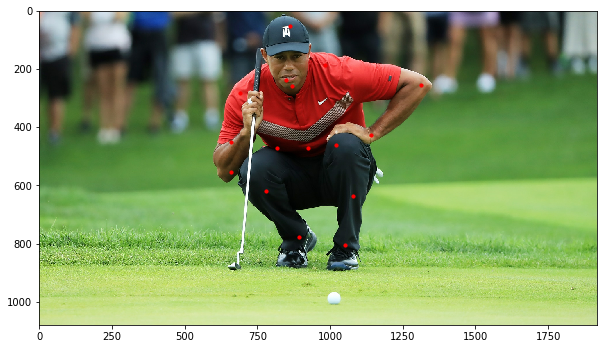

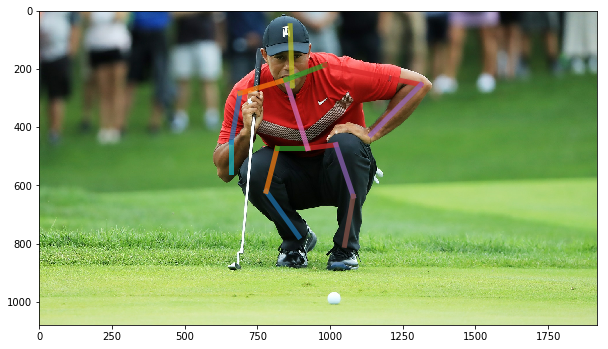

In [ ]:
image, keypoints = predict("test_image.jpg")
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)